# The Past 10 Years In The US: As Viewed From K Street

D.C. is a strange place, to me at least. American Politicians, while rely on a large coalition base to assume and keep power, can often get away with quite some personal gains at the cost of public good. In my opinion the U.S. political machine is fueled by as much populism as it is elitism. We know what we the people are thinking, we have Facebook and various other polls telling us "what Americans consider important"; but what are the elites thinking?  

Although my political view about this particular topic (lobbying) is obscure, I'd like to understand that and how their opinions have shaped the policies of this country.  

I found an interesting dataset on [OpenSecrets.org](http://www.opensecrets.org/myos/download.php?f=Lobby.zip) and one of the files (lob_issue.txt) contains some very good information. The 'specific issue' column provides very detailed information about the issues being lobbied. This is almost like a poll asking the elites "what do you think are the most/least important things this year". And my idea is to explore the main themes lobbied by K street and see how that has changed over time.  

I am also particularly interested in the years right before and right after outburst of the financial meltdown, which are conveviently included in the dataset.

In [ ]:
import pandas as pd
import numpy as np
import re
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

## Data wrangling

Turns out the file is not very clean, some rows are completely misaligned. So I removed all newlines and used the actual marker at beginning of each record ",|" instead. I suspect other files in the dataset are anything special so hopefully this will help cleaning up those files.

In [109]:
string = open('lob_issue.txt').read()
new_str = re.sub('[\r\n]', ' ', string)
new_str = re.sub('([0-9])+\,\|', '\r\n', new_str)
data = pd.DataFrame(new_str.split('\r\n'))
data = data[0].str.split('|', return_type='frame')[[0,2,4,6,8]]
data.columns = ['Uniqid',
'IssueID',
'Issue',
'SpecificIssue',
'Year']

In [84]:
#data.to_csv('clean_issue_tokenized.csv',index=False)
#data = pd.read_csv('clean_issue_tokenized.csv')

Here is an example of a 'specific issue'

In [4]:
data[data.Year==2001]['SpecificIssue'].iloc[0]

'H.R. 442 - Increases VA loan limits  H.R. 674 - "Homeownership Opportunities for Uniformed Services and Educators Act"  S. 417 - "Homeownership Opportunities for Uniformed Services and Educators Act"  H.R. 858 - "FHA Downpayment Simplification Act"  H.R. 914 - "ADA Notification Act"  S. 782 - "ADA Notification Act"  S. 1163 - "FHA Multifamily Housing Mortgage Loan Limit Adjustment Act"  H.R. 1629 - "FHA Multifamily Housing Mortgage Loan Limit Adjustment Act"  FY 2002 VA/HUD Appropriations bill  S. 1088 - "Veterans\' Benefits Improvements Act" - provision increasing the veterans\' guaranty amount  S. 1254 - "Mark-to-Market Extension Act"  H.R. 3661 - "FHA Downpayment Simplification Act"  Department of Housing and Urban Development - Issues regarding Section 8 and RESPA  Department of Veterans\' Affairs - proposed rule requiring first-time homebuyers to complete homeownership counseling'

Next step is to extract keywords from specific issues. I used the following criteria:  

1. Remove anything that's digits ONLY;
2. Remove anything in the common English stop words list;
3. Choose only alphabet-based words that doesn't look like "FY2011", and capitalize the first letter. "FY2011" is meaningless as they are usually unique to the fiscal year therefore will easily out-index other keywords.

And below shows the cleaned up specific issue from the above cell. Note that each word is counted once within a specific issue, to prevent issues with many repeated words to flood the result with uninformative keywords.

In [186]:
stop_words = stopwords.words('english')
def filter_words(s):
    if s['SpecificIssue'] == s['SpecificIssue']:
        issue_words = s['SpecificIssue'].split(' ')
        issue_words = [word for word in issue_words if not word.isdigit()]
        issue_words = [word for word in issue_words if word not in stop_words]
        issue_words = [re.sub(r'[^\w]', '', word).title() for word in issue_words 
                       if ((re.match('([a-zA-Z])+\w',word)) and not
                           (re.match('([Ff][Yy]\d+)',word)))]
        issue_words = list(set(issue_words))
    else:
        issue_words = [""]
    return ','.join(issue_words)
filter_words(data[data.Year==2001].iloc[0])

'Affairs,Mortgage,Simplification,Housing,Opportunities,Department,Firsttime,Increasing,Veterans,Development,Urban,Extension,Section,Multifamily,Fy,Respa,Increases,Notification,Services,Provision,Downpayment,Regarding,Vahud,Benefits,Homeownership,Limits,Appropriations,Bill,Rule,Amount,Limit,Act,Uniformed,Complete,Va,Guaranty,Proposed,Educators,Requiring,Loan,Improvements,Counseling,Adjustment,Issues,Homebuyers'

It's a fairly big file, hence the multiprocessing.  

Also data before 07 do not have complete specific issue logs. 07 is the first year with over 50% of the issues logged specifically.

In [ ]:
import multiprocessing

def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
    workers = kwargs.pop('workers')
    pool = multiprocessing.Pool(processes=workers)
    result = pool.map(_apply_df, [(d, func, kwargs)
            for d in np.array_split(df, workers)])
    pool.close()
    return pd.concat(list(result))

df_post_07 = data[data['Year']>=2007]
df_post_07['tokenized'] = apply_by_multiprocessing(df_post_07, filter_words, axis=1, workers=10)

## Analysis

This is similar to the TF-IDF measure of word importance (more properly called term probability). This is altered, or simplified because the structure here is a 4 level hierarchy with terms, documents(issues), year and all years (corpus):  

tf(t) is the number of specific issues with word t divided by count of word/issue combinations.  
tr_y(t) is the number of specific issues with word t divided by count of word/issue combinations during year y.  

index(t) = tf_y(t)/tf(t), which numerically means how much more likely does term t occur at year y than in the entire file.  

The accurate representation of word importance is not the key issue here, and instead the minimum occurrence threshold as I will explore later.

In [137]:
tf = pd.DataFrame.from_dict(Counter(
        df_post_07[df_post_07['tokenized']==df_post_07['tokenized']]['tokenized'].str.cat(sep=',').split(',')
                                   ), orient='index').reset_index()
tf.columns = ['key','frequency']
tf['prob'] = tf['frequency']/tf['frequency'].sum()

## Results
The top 50 highest and lowest indexed keywords are plotted on a word cloud for each year. Font size is the frequency of word in each year, not the index.

In [256]:
# overindex_freq and underindex_freq are key to the selection criteria
underindex_freq = 100
overindex_freq = 100
def plot_year(y):
    tf_y = pd.DataFrame.from_dict(Counter(df_post_07[(df_post_07['Year']==y)&(
                df_post_07['tokenized']==df_post_07['tokenized'])]['tokenized'].str.cat(sep=',').split(',')
                                   ), orient='index').reset_index()
    tf_y.columns = ['key','frequency']
    tf_y['prob'] = tf_y['frequency']/tf_y['frequency'].sum()
    tfidf = tf_y.merge(tf,how='left',on=['key'])
    tfidf['score'] = tfidf['prob_x'].astype(float)/tfidf['prob_y'].astype(float)
    words = tfidf[tfidf['frequency_y']>=underindex_freq].sort('score',axis=0,ascending=True).head(50)
    text = ((words['key'].astype(str)+",")*words['frequency_x']).str.cat(sep=',')
    wordcloud = WordCloud(width=800, height=400, max_words = 50).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(str(y)+": Under-indexed",fontsize=30)
    wordcloud = WordCloud(width=800, height=400, max_words = 50).generate(text)
    plt.figure()
    words = tfidf[(tfidf['frequency_x']>=overindex_freq)&(tfidf['score']<1
                                              )].sort('score',axis=0,ascending=False).head(50)
    text = ((words['key'].astype(str)+",")*words['frequency_x']).str.cat(sep=',')
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(str(y)+": Over-indexed",fontsize=30)
    plt.show()

2007: Nobody has paid attention to derivatives yet and fracturing is being applied on a commercial scale to shales in the United States not until 2013 according to Wikipedia. Also the midwest flooding made it into the over-indexed picture.  

2008: Look away, nothing is happening on Wall st. But seriously they are actually lobbying legislation, which may or may not have been targeted at Wall st.  

2009: let's forget about cutting, just do something PERTAINING FEDERAL ACCOUNTABILITY! 

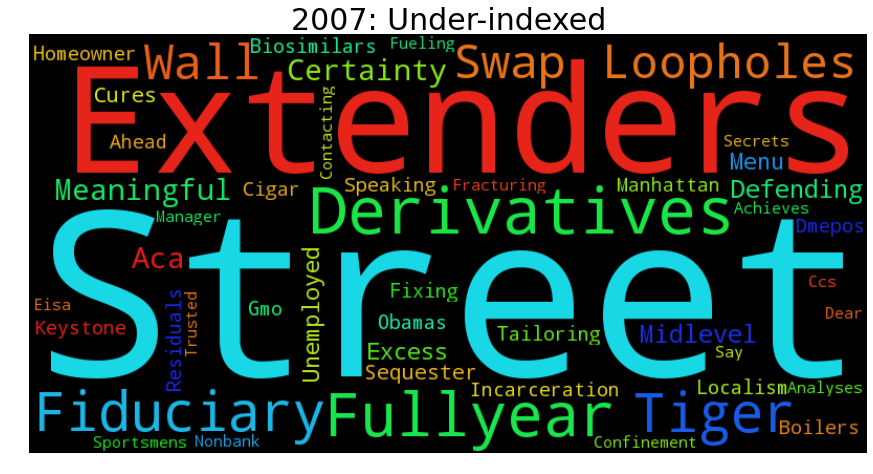

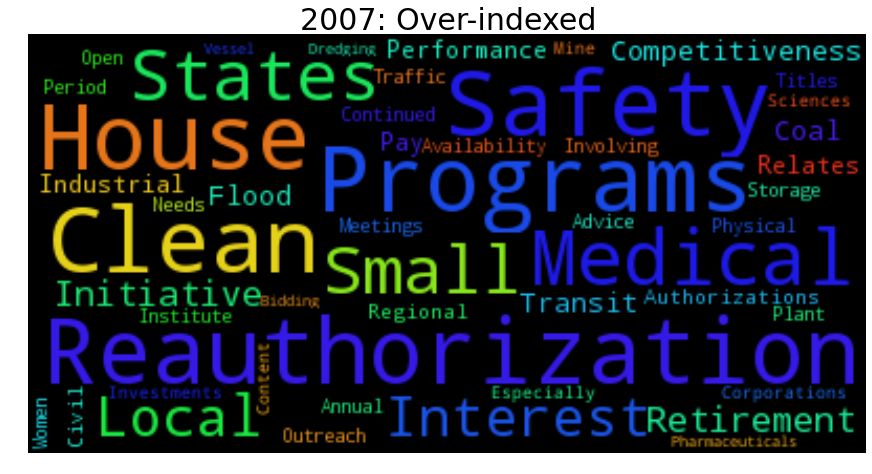

In [257]:
plot_year(2007)

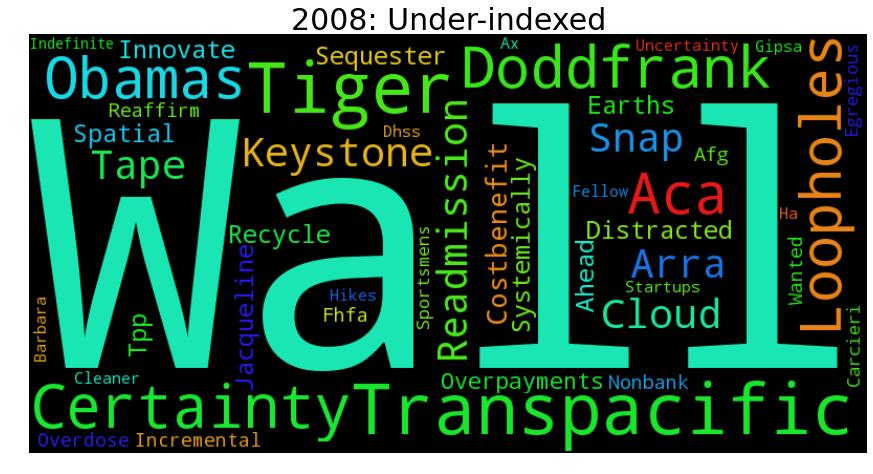

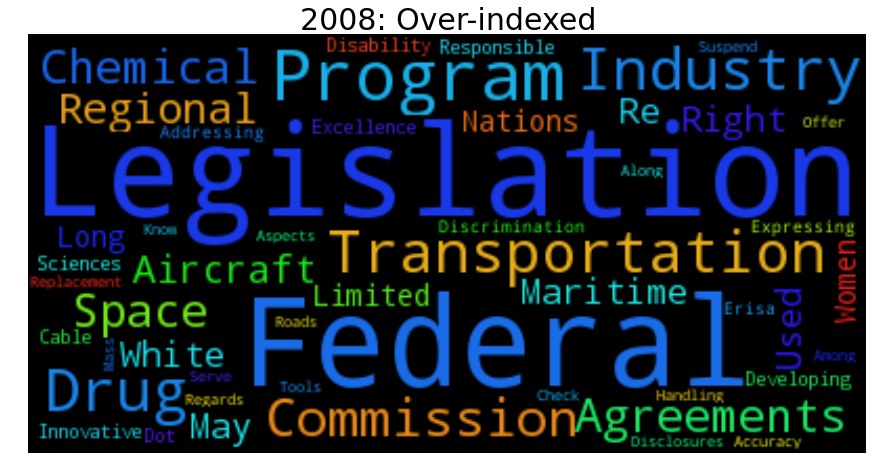

In [242]:
plot_year(2008)

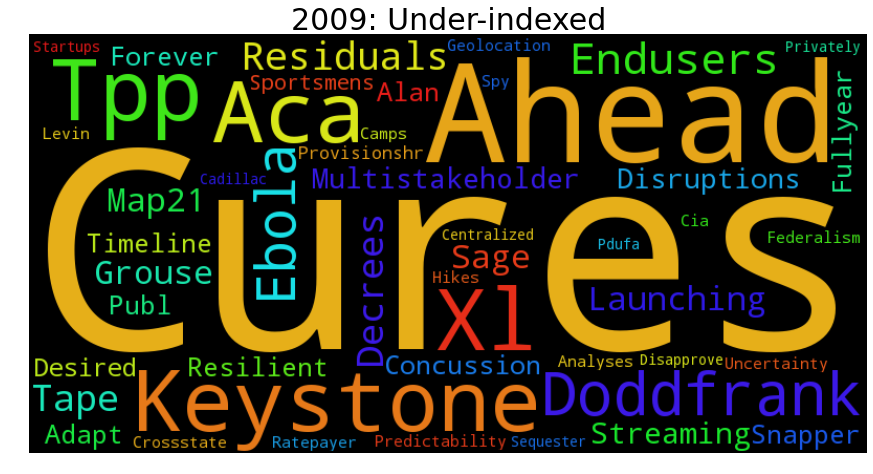

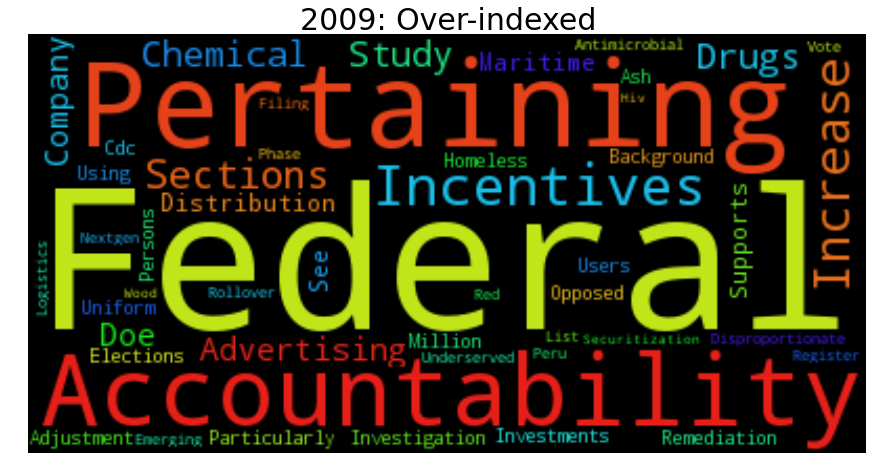

In [243]:
plot_year(2009)

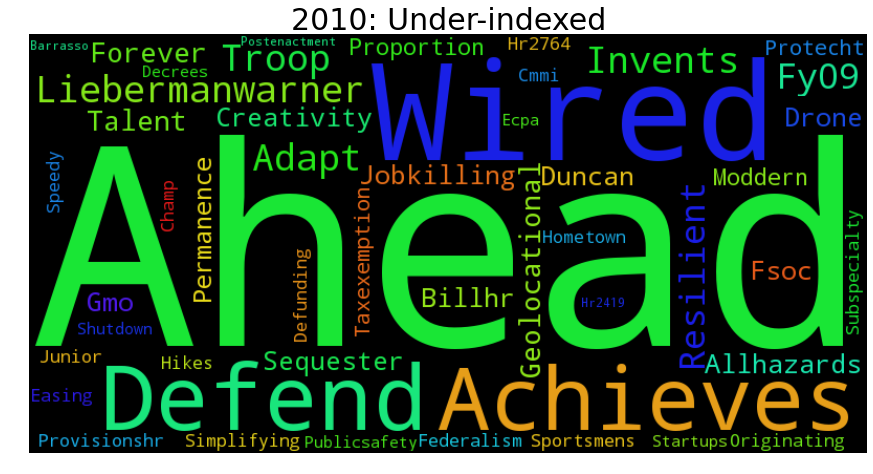

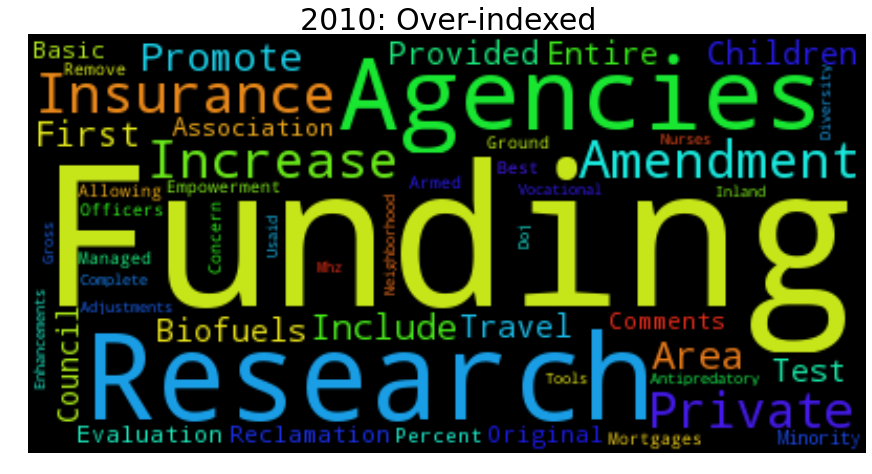

In [244]:
plot_year(2010)

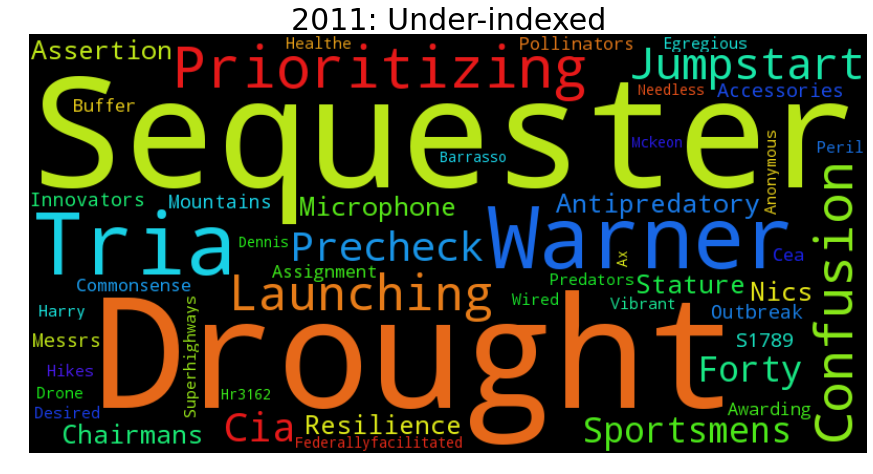

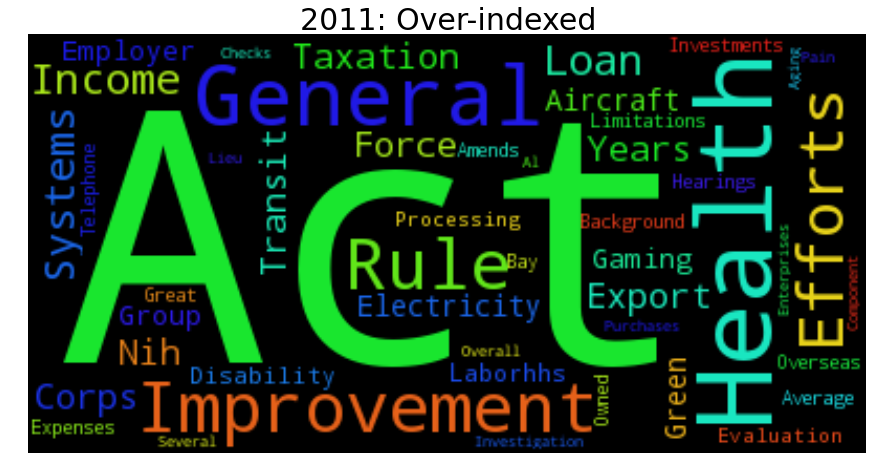

In [245]:
plot_year(2011)

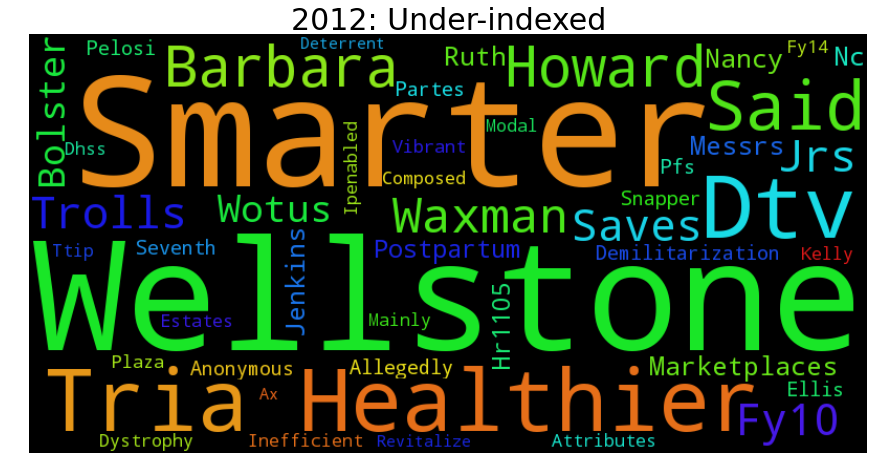

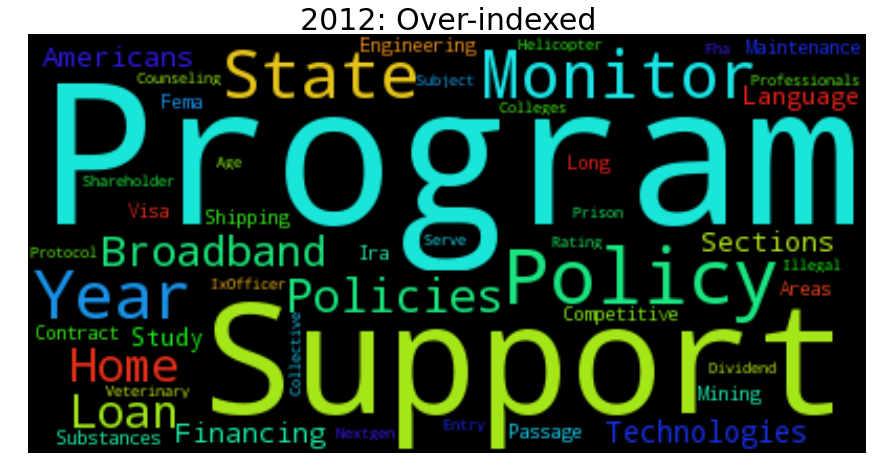

In [246]:
plot_year(2012)

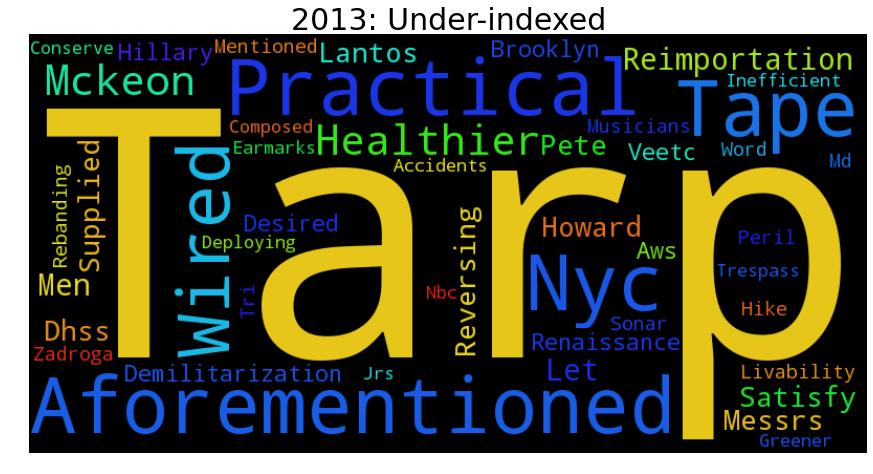

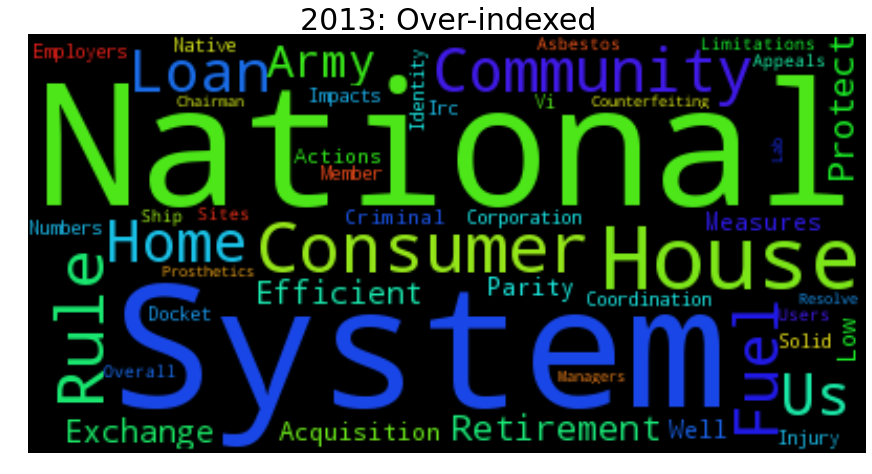

In [247]:
plot_year(2013)

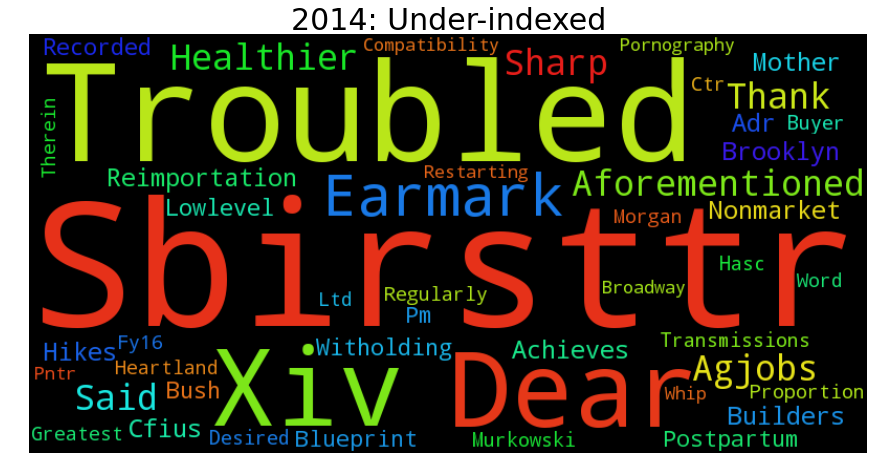

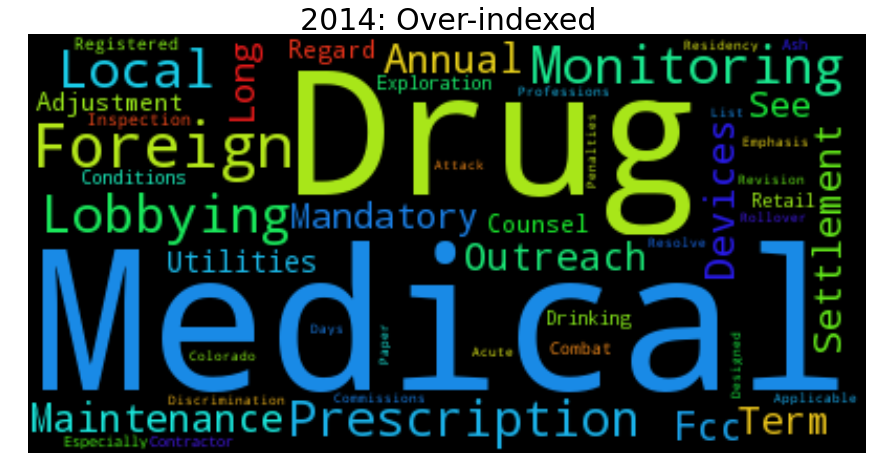

In [248]:
plot_year(2014)

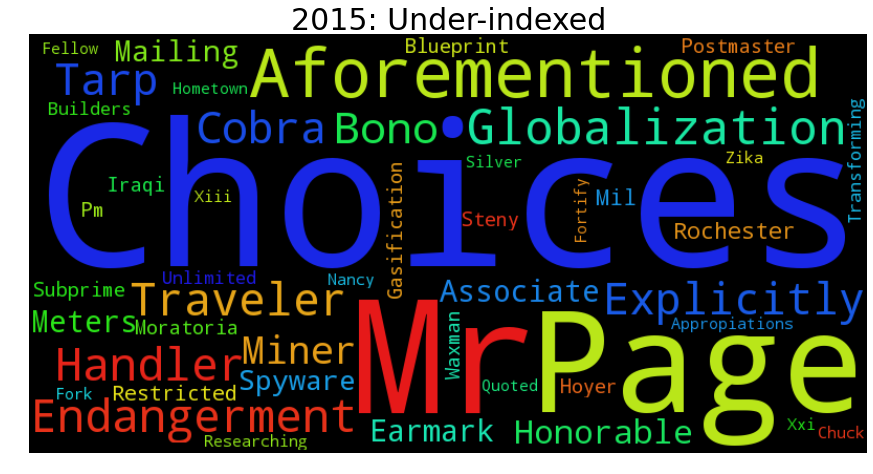

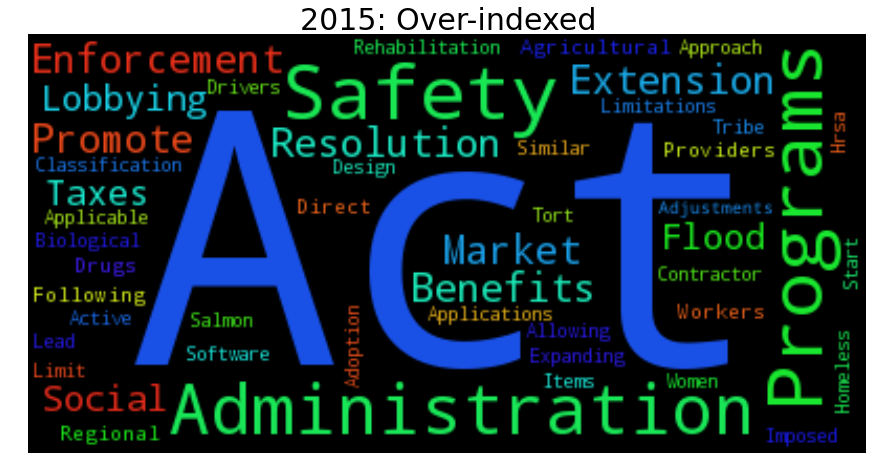

In [249]:
plot_year(2015)

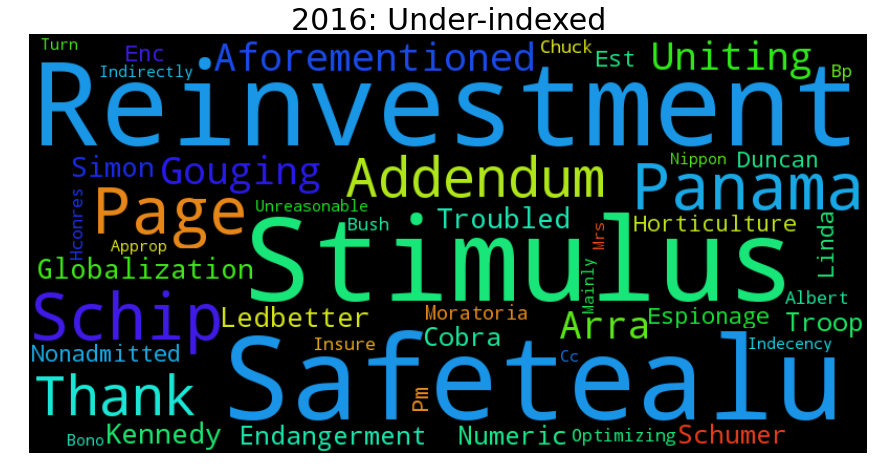

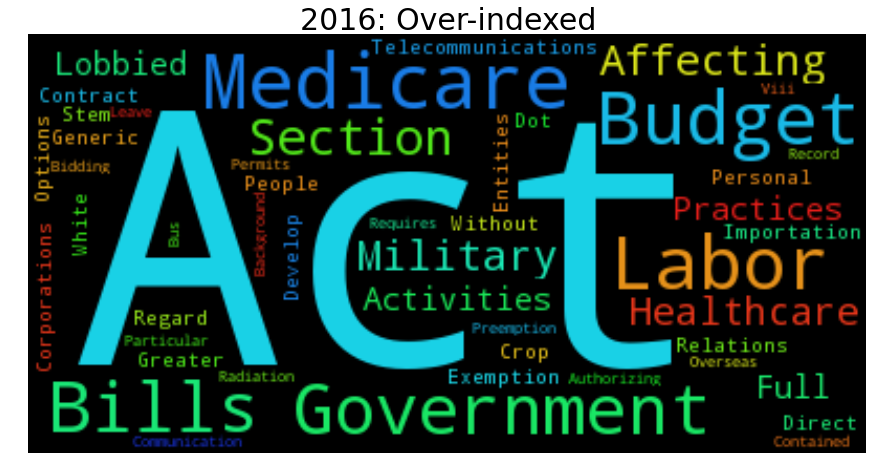

In [250]:
plot_year(2016)

## Final words

After the initial scrambling of the financial crisis, K street has turned its attention to healthcare. It does appear the affordable care act has created a market for power - more regulation means rent seeking is more profitable. There is enormous populist appeal (cheaper insurance, higher coverage etc.) on the surface but the more regulated market also offers, under the table, policies to be sold to the highest bids.  